In [1]:
import os
import json

import pandas as pd

import torch
import torchvision  
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from loguru import logger


/home/pyml/anaconda3/envs/objrecognition/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def get_fasterrcnn_model(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights="DEFAULT"
    )

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_features, num_classes
    )

    return model


### Build dataset

In [3]:
# Define the label mapping
label2idx = {
    "person": 1,
    "car": 2,
    "bicycle": 3,
    "motorcycle": 4,
    "bus": 5,
    "truck": 6
}

# Function to convert string labels to numerical labels
def convert_labels_to_numbers(labels):
    return [label2idx[label] for label in labels]

In [4]:
# Define the dataset class
class MyDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transforms=None, tag="train"):
        self.transforms = transforms
        self.tag = tag
        df = pd.read_csv(csv_file)
        df_selected = df[df["tag"] == tag]
        self.img_files = df_selected["imagepath"].values
        self.annot_files = df_selected["labelpath"].values

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.annot_files[idx]
        img = read_image(img_path)
        with open(mask_path, "rt") as f:
            d_json = json.load(f)
        # example:
        # [{"label": "person", "x": 167, "y": 162, "width": 310, "height": 465}]
        num_objs = len(d_json)

        labels = convert_labels_to_numbers(
            [obj["label"] for obj in d_json]
        )
        boxes_xywh = [
            (obj["x"], obj["y"], obj["width"], obj["height"])
            for obj in d_json
            if (obj["width"] > 0) and (obj["height"] > 0)
        ]
        boxes_xywh = torch.tensor(boxes_xywh, dtype=torch.float32)
        boxes = torchvision.ops.box_convert(
            boxes_xywh, in_fmt="xywh", out_fmt="xyxy"
        )
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = idx

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        if self.tag == "test":
            return img_path, img, target

        return img, target


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [6]:
import sys
import pprint
sys.path.append("code")
from detection_tools import utils


dataset = MyDetectionDataset(
    "data/data.csv",
    transforms=get_transform(train=True),
    tag="train"
)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

num_classes = len(label2idx) + 1  # 0: background, 1...N: classes
model = get_fasterrcnn_model(num_classes=num_classes)


# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(pprint.pformat(output))


# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions

print(pprint.pformat(predictions[0]))

{'loss_box_reg': tensor(0.3459, grad_fn=<DivBackward0>),
 'loss_classifier': tensor(1.9118, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.0169, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0589, grad_fn=<DivBackward0>)}
{'boxes': tensor([[  0.0000,  13.2525, 175.8021, 274.7580],
        [  0.0000,  12.1263, 400.0000, 283.3992],
        [148.4861, 218.5866, 152.2368, 222.1959],
        [171.0760, 207.1064, 174.4090, 210.8221],
        [170.7621, 204.1026, 174.2206, 207.6621],
        [148.4420, 219.8640, 152.3280, 223.5092],
        [  0.0000,  12.4223, 326.1519, 151.4088],
        [  0.0000, 146.8744, 228.3346, 300.0000],
        [ 56.4389,  72.8895, 370.1238, 300.0000],
        [155.5368, 220.0774, 159.2421, 224.1760],
        [148.5722, 217.0234, 152.2113, 220.8917],
        [172.1327, 203.6167, 175.6289, 207.2856],
        [155.7703, 221.2975, 159.3899, 225.5992],
        [269.9414,  75.6550, 274.1218,  80.7125],
        [154.6595, 220.

###  Train the model

In [ ]:
from detection_tools.engine import train_one_epoch, evaluate

os.makedirs("checkpoints", exist_ok=True)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_train = MyDetectionDataset(
    "data/data.csv",
    transforms=get_transform(train=True),
    tag="train"
)
dataset_val = MyDetectionDataset(
    "data/data.csv",
    transforms=get_transform(train=False),
    tag="val"
)

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# build the model
num_classes = len(label2idx) + 1  # 0: background, 1...N: classes
model = get_fasterrcnn_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(
        model, optimizer, data_loader,
        device, epoch, print_freq=100
    )
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_loader, device=device)

# Save the model
torch.save(
    model.state_dict(),
    os.path.join("checkpoints", "model.pth")
)

### Evaluation on test-set

In [10]:
# Load the model
model = get_fasterrcnn_model(num_classes)
model.load_state_dict(
    torch.load(os.path.join("checkpoints", "model.pth"))
)
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
dataset_test = MyDetectionDataset(
    "data/data.csv",
    transforms=get_transform(train=False),
    tag="test"
)

### Visualize predictions of a sample

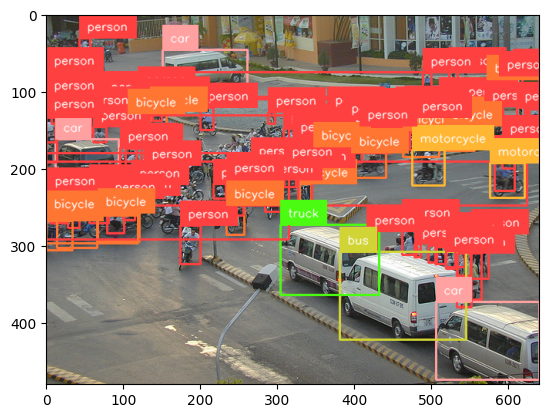

In [21]:
from PIL import Image
import supervision as sv

img_path, img, target = next(iter(dataset_test))
img = img.to(device)
with torch.no_grad():
    pred = model([img])

# Apply NMS
keep = torchvision.ops.nms(
    pred[0]["boxes"],
    pred[0]["scores"],
    iou_threshold=0.5
)

detections = sv.Detections(
    xyxy=pred[0]["boxes"][keep].cpu().numpy(),
    class_id=pred[0]["labels"][keep].cpu().numpy(),
)
labels = [
    (["backgroun"] + list(label2idx.keys()))[i]
    for i in pred[0]["labels"][keep].cpu().numpy()
]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

img = Image.open(img_path)
annotated_img = box_annotator.annotate(img, detections)
annotated_img = label_annotator.annotate(
    annotated_img, detections=detections,
    labels=labels
)

import matplotlib.pyplot as plt
plt.imshow(annotated_img)
plt.show()

In [22]:
import json
from tqdm import tqdm


res_dir = "results/faster_rcnn"
os.makedirs(res_dir, exist_ok=True)

for i, (img_path, img, target) in tqdm(enumerate(dataset_test)):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    # Apply NMS:
    # note that predicted boxes are in xyxy format
    # (as expected for NMS)
    keep = torchvision.ops.nms(
        prediction[0]["boxes"],
        prediction[0]["scores"],
        iou_threshold=0.5
    )

    res = {
        "image_path": img_path,
        "boxes_xyxy": prediction[0]["boxes"][keep].cpu().numpy().tolist(),
        "labels": prediction[0]["labels"][keep].cpu().numpy().tolist(),
        "scores": prediction[0]["scores"][keep].cpu().numpy().tolist()
    }

    # save prediction as json
    filename = os.path.basename(img_path)
    with open(os.path.join(res_dir, filename.replace(".jpg", ".json")), "wt") as f:
        json.dump(res, f)


2968it [01:23, 35.47it/s]
